In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tarfile
from tensorflow.keras import Sequential, layers, utils

### 1.(4) Реализуйте алгоритм логистической регрессии со стохастическим градиентным спуском. Градиентный спуск нужно делать пока уменьшается ошибка на test датасете. Выведите график зависимости точности от итерации на датасетах cancer.csv и spam.csv.

In [2]:
def load_reg_data(name):
    data = pd.read_csv("../data/" + name + ".csv")
    if name == "cancer":
        mapping = {'M': 1, 'B': -1}
    else:
        mapping = {0: -1}
    
    X, y = data.drop("label", axis=1).values, data.replace({'label': mapping})["label"].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_ = np.c_[np.ones(X.shape[0]), X]

    return train_test_split(X_, y)

In [3]:
def regress(train_X, test_X, train_y, test_y, batch_size=15, learning_rate=0.5):
    accuracy_prev = -np.inf
    w = np.random.rand(train_X.shape[1])
    iters = 0 
    accuracies = []
    
    while True:
        batch_idx = np.random.choice(train_X.shape[1], batch_size, replace=False)
        ybatch = train_y[batch_idx]
        Xbatch = train_X[batch_idx, :]

        a = -np.mean((Xbatch.T * ybatch) / (1 + np.exp(((Xbatch * w).T * ybatch))), axis=1)
        w -= learning_rate * a

        h = np.sign(np.sum(np.tile(w, (test_X.shape[0], 1)) * test_X, axis=1))
        accuracy_cur = accuracy_score(test_y, h)
        
        if accuracy_cur >= accuracy_prev:
            accuracy_prev = accuracy_cur
            accuracies.append(accuracy_prev)
            iters += 1
        else:
            print("Accuracy on test: " + str(accuracy_prev) + " with " + str(iters) + " iterations")
            plt.plot(accuracies, '-')
            plt.xlabel('iteration')
            plt.ylabel('accuracy')
            return w

Accuracy on test: 0.9230769230769231 with 10 iterations


array([-0.59237353,  1.30131884,  0.92977996,  1.49040616,  1.54275742,
        0.52985416,  1.02541851,  1.35700648,  1.43072082,  0.42767164,
        0.19144801,  1.57796919,  0.86421228,  1.32165931,  1.25857548,
        0.13826199,  1.11997068,  1.11403634,  1.48454661,  0.45190322,
        0.91094844,  1.36746101,  0.98170398,  1.52333488,  1.21864185,
        0.28950124,  0.78446546,  1.17817766,  1.56022324,  0.49385895,
        0.69243813])

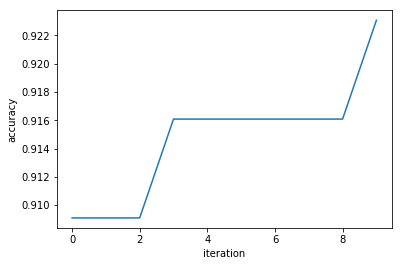

In [4]:
regress(*load_reg_data("cancer"))

Accuracy on test: 0.8323197219808862 with 5 iterations


array([-0.58475639,  0.46531336,  0.38836946,  0.72611519,  1.0226096 ,
        0.89562348,  1.15218369,  1.02691699,  0.9555424 ,  0.76221275,
        0.09012988,  0.61178546,  0.15501289,  0.84775457,  0.56797653,
        0.30844068,  0.99931578,  1.18976085, -0.01500484,  0.78044302,
        0.88800759,  0.99344176,  0.76821038,  0.73937191,  1.00426716,
       -0.02600275,  0.28182596,  0.26849704,  0.26189283,  0.46715248,
        0.14757868, -0.24955176,  0.79754534,  0.53186462,  0.91864703,
        0.00991934, -0.30624424, -0.32655827,  0.96416976, -0.42047515,
        0.28283805, -0.40584276, -0.00750631,  0.11217026, -0.82652048,
       -1.00626212,  0.10263776,  0.51682292,  0.28980429, -0.08339771,
        0.67666496,  0.60895546, -0.25375537,  0.81237445,  1.04739256,
        0.81613225,  0.69689305,  0.43627411])

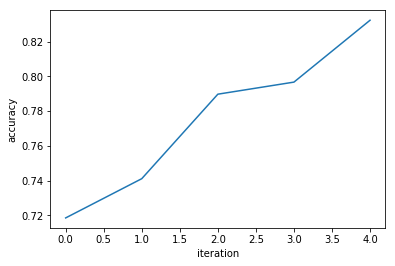

In [6]:
regress(*load_reg_data("spam"), batch_size=10, learning_rate=0.8)

### 2.(2) Преобразуйте датасеты mnist и notMNIST так, чтобы каждая точка представляла собой квадратную матрицу.

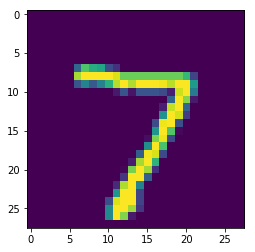

In [52]:
mnist_df = pd.read_csv("../data/mnist.csv") 
mn_X = mnist_df.drop("label", axis=1).values.reshape(mnist_df.shape[0], 28, 28, 1)
mn_y = mnist_df["label"].values
mn_y = utils.to_categorical(mn_y, 10)
mn_train_X, mn_test_X, mn_train_y, mn_test_y = train_test_split(mn_X, mn_y)

plt.imshow(mn_X[0,:,:,0])
plt.show()

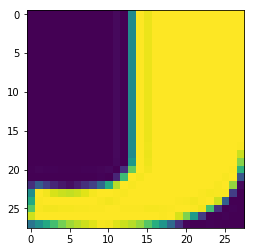

In [47]:
nmn_X = []
nmn_y = []
with tarfile.open("../data/notMNIST.tar.gz", mode='r') as notmnist:
    for m in notmnist.getmembers():
        if m.name.endswith("png"):
            try:
                nmn_X.append(plt.imread(notmnist.extractfile(m)))
                nmn_y.append(ord(m.name.split("/")[1]) - ord('A'))
            except OSError:
                continue
    
nmn_X = np.array(nmn_X)
nmn_X = nmn_X.reshape(nmn_X.shape[0], 28, 28, 1) / 255
nmn_y = np.array(nmn_y)
nmn_y = utils.to_categorical(nmn_y)

nmn_train_X, nmn_test_X, nmn_train_y, nmn_test_y = train_test_split(nmn_X, nmn_y)

plt.imshow(nmn_X[0,:,:,0])
plt.show()

### 3.(4) Создайте сеть из трех сверточных слоев по 8 сверток 3х3 и двух полносвязных слоев по 64 нейрона. Обучите сеть на датасете mnist с тремя разными функциями активации в слоях (sigmoid, tanh, ReLU).

In [55]:
model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(8, (3, 3), activation='tanh'))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(10, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 22, 22, 8)         584       
_________________________________________________________________
flatten_17 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                247872    
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_52 (Dense)             (None, 10)                650       
Total para

In [56]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(mn_train_X, mn_train_y, epochs = 20)
test_loss, test_acc = model.evaluate(mn_test_X, mn_test_y)
print("Accuracy on test", test_acc)

Epoch 1/20
7500/7500 [==============================] - 6s 843us/step - loss: 1.3722 - acc: 0.7403
Epoch 2/20
7500/7500 [==============================] - 5s 692us/step - loss: 0.3680 - acc: 0.9483
Epoch 3/20
7500/7500 [==============================] - 5s 648us/step - loss: 0.1654 - acc: 0.9717
Epoch 4/20
7500/7500 [==============================] - 5s 684us/step - loss: 0.0954 - acc: 0.9849
Epoch 5/20
7500/7500 [==============================] - 5s 675us/step - loss: 0.0594 - acc: 0.9911
Epoch 6/20
7500/7500 [==============================] - 5s 710us/step - loss: 0.0375 - acc: 0.9949
Epoch 7/20
7500/7500 [==============================] - 5s 727us/step - loss: 0.0236 - acc: 0.9980
Epoch 8/20
7500/7500 [==============================] - 5s 694us/step - loss: 0.0163 - acc: 0.9985
Epoch 9/20
7500/7500 [==============================] - 5s 697us/step - loss: 0.0117 - acc: 0.9991
Epoch 10/20
7500/7500 [==============================] - 5s 707us/step - loss: 0.0089 - acc: 0.9996
Epoch 11/

### 4.(6) Достигните точности 87% на test датасете notMNIST. Архитектура сети может быть любая. Можно использовать Data Augmentation.


In [51]:
model = Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(8, (3, 3), activation='tanh'))
model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(nmn_train_X, nmn_train_y, epochs = 20)
test_loss, test_acc = model.evaluate(nmn_test_X, nmn_test_y)
print("Accuracy on test", test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 22, 8)         584       
_________________________________________________________________
flatten_15 (Flatten)         (None, 3872)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                247872    
_________________________________________________________________
dense_45 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_46 (Dense)             (None, 10)                650       
Total para